In [1]:
import re
import os
import shutil
import zipfile
import random
import numpy as np
import pandas as pd
from pathlib import Path
# from ast import literal_eval
from transformers import BertTokenizer,  BertConfig, TFBertModel
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2021-08-22 11:03:48.877639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
cd /mnt/demo/transformers_tutorial/relation_extraction/

/mnt/demo/transformers_tutorial/relation_extraction


In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus[-1])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-08-22 11:03:52.223840: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-22 11:03:52.232499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-22 11:03:52.322380: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-08-22 11:03:52.323035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2021-08-22 11:03:52.323236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-22 11:03:52.358753: I tensorflow/stream_executor/platfor

# 数据集整理
## 读取数据
### 压缩和解压zip文件

In [4]:
def unzip(zipPath, dp=None):  
    """
    Unzip zip file to a folder
     
    Parameters
    ---------
    zipPath: Zip file path 
    dp: Decompression path

    Returns
    ---------
    dir_path: The path of the extracted folder

    Raises
    ---------
    """
    if dp == None:
        ## By default, it is decompressed to the current directory
        dp = zipPath.rsplit('.', 1)[0]
    with zipfile.ZipFile(zipPath, 'r') as f:
        for fn in f.namelist():
            f.extract(fn, dp)
    return dp
            
def zipFolder(dfp, out_path=None):
    """
    Compresses the specified folder

    Parameters
    ---------
    dfp: Destination folder  or file path.
    out_path: Save path of the compressed file +xxxx.zip.

    Returns
    ---------
    """

    if os.path.isdir(dfp):   
        if out_path == None:
            out_path = dfp + '.zip'
        with zipfile.ZipFile(out_path, "w", zipfile.ZIP_DEFLATED) as f:
                for root, dirnames, filenames in os.walk(dfp):
                    for fn in filenames:
                        f.write(filename=os.path.join(root, fn), arcname=fn)
    else:
        if out_path == None:
            out_path = dfp.rsplit('.', 1)[0] + '.zip'
        with zipfile.ZipFile(out_path, "w", zipfile.ZIP_DEFLATED) as f:
            f.write(dfp, dfp.rsplit('/', 1)[1])
    print(out_path)
    
# zipFolder('./data/test/三元组数据集_云测早期标注')
# zipFolder('data/ABC.json')

# unzip('./data/test/三元组数据集_内部标注.zip')
# dir_path = unzip('./data/三元组数据集_云测8.17前标注.zip')
# print(dir_path)

### 处理解压的文件中的乱码和文件夹复用问题

In [5]:
def rm_fileOrFolder(fp):
    '''
    remove file or folder
    '''
    if os.path.exists(fp):
        if os.path.isfile(fp):
            os.remove(fp)
        else:
            # The folder cannot be deleted for unknown reasons
            shutil.rmtree(fp)
            
def rename_correctly(string):
    '''
    Rename the garbled characters extracted from the window package
    '''
    try:
        new_string = string.encode('cp437').decode('utf-8')
    except:
        try:
            new_string = string.encode('cp437').decode('gbk')
        except:
            new_string = string.encode('utf-8').decode('utf-8')
    return  new_string

# fp = 'data/╚²╘¬╫Θ╩²╛▌╝»_─┌▓┐▒Ω╫ó'
# rename_correctly(fp)


def rm_specialNameFolder(folder_name='__MACOSX'): 
    '''
    Delete the folder named 'xxxx' if it exists.
    The default folder name is __MACOSX.
    '''
    for root, dirs, files in os.walk(dir_path, topdown=False):
        for name in dirs:
            if name == folder_name :
                shutil.rmtree(os.path.join(root, name))  

def standard_zipDir(dir_path):
    for root, dirs, filenames in os.walk(dir_path):
        for fn in filenames:
            fp = os.path.join(root, fn)
            new_fp = os.path.join(dir_path, rename_correctly(fn))
            os.rename(fp, new_fp)
            
    for root, dirs, filenames in os.walk(dir_path):
        for folder in dirs:
            dp = os.path.join(root, folder)
            rm_fileOrFolder(dp)
            rm_specialNameFolder()

# dir_path = unzip('./data/三元组数据集_云测早期标注.zip')
# dir_path = unzip('./data/归档.zip')
# print(f'dir_path +++++++++ {dir_path}')
# standard_zipDir(dir_path)

### 读取三元组数据json文件

In [6]:
def json_to_df(path, nrows=False):
    '''
    Read a TRIplet data JSON file
    
    Parameters
    ---------    
    path: file path
    nrows: int, optional
           The number of lines from the line-delimited jsonfile that has to be read
           The default is false, all the rows will be returned.
    Returns
    ---------  
    df: DataFrame
    '''
    if nrows:
        df = pd.read_json(path, nrows=nrows, lines=True)
    else:
        df = pd.read_json(path, lines=True)
    df = df[['text', 'spo_list']]
    return df

### 从zip或文件夹中读取多个三元组json文件

In [7]:
def merge_df(path):
    if path.rsplit('.', 1)[1]=='zip':
        dir_path = unzip(path)
        standard_zipDir(dir_path)
    else:
        dir_path = path
    total_df = pd.DataFrame()
    for fn in os.listdir(dir_path):
        df = json_to_df(os.path.join(dir_path, fn))
        df_fn = fn[:fn.rfind('.')]
        df.insert(0, 'fn', df_fn)
        total_df =  total_df.append(df)
    total_df.reset_index(drop=True, inplace=True)
    print(f'original data size: {total_df.shape}') #
    # print(f'original data sample: {df.sample(5)}\n')
    return total_df  

path1 = './data/三元组数据集_内部标注.zip'
merge_df(path1)

NameError: name 'dir_path' is not defined

### 读取关系标签数

In [ ]:
def read_schemads(path_or_df):
    if not isinstance(path_or_df, pd.DataFrame):
        schemads_path = path_or_df
        predicate_data = pd.read_json(schemads_path, lines=True)
        id2p = predicate_data['predicate'].drop_duplicates().reset_index(drop=True).to_dict()
    else:
        df = path_or_df
        id2p = df['spo_list'].apply(lambda spo_list: [spo['predicate'] for spo in spo_list])
        id2p = id2p.explode().drop_duplicates().reset_index(drop=True).to_dict()
    p2id = dict(zip(id2p.values(), id2p.keys()))
    print(f'length of p2id :{len(p2id)}')#
    print(f'random p2id sample:{random.sample(p2id.items(), 5)}')#
    return id2p, p2id

## 招股说明书三元组数据集

In [ ]:
path1 = './data/三元组数据集_云测早期标注.zip'
df1 = merge_df(path1)

path2= './data/三元组数据集_内部标注'
df2= merge_df(path2)

path3= './data/三元组数据集_云测8.17前标注.zip'
df3= merge_df(path3)

df = pd.concat([df1, df2, df3], ignore_index=True)
print(f'df.shape: {df.shape}')
id2p, p2id = read_schemads(df)

original data size: (9500, 3)
original data size: (837, 3)


## 清洗数据

In [ ]:
def clean_spo(spo_list):
    for spo in spo_list:
        spo['predicate'] = spo['predicate'].lower()
        spo['subject'] = spo['subject'].lower()
        spo['object'] = spo['object'].lower()
    return spo_list

def data_clean(df):
    df.dropna(how='any', inplace=True)
    df = df[df['spo_list'].apply(lambda x: len(x)>0)]
    df.drop_duplicates(subset=['text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['text'] = df['text'].str.lower()
    df['spo_list'] = df['spo_list'].apply(clean_spo)
    print(f'Real data size is {df.shape[0]}')
    return df
    
df = data_clean(df)

Real data size is 14515


## 划分数据集

In [ ]:
train_size=0.9
train_data = df.sample(frac=train_size,random_state=200)
dev_data = df.drop(train_data.index)
dev_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)
print(f'Train data size: {train_data.shape}') #
print(f'Validation data size: {dev_data.shape}') 

train_text = train_data['text'].to_list()
train_spo = train_data['spo_list'].to_list()

dev_text = dev_data['text'].to_list()
dev_spo = dev_data['spo_list'].to_list()

Train data size: (13064, 3)
Validation data size: (1451, 3)


## 标签集分布

Total number of p2id category is 164, actual number of labels that meet the requirements is 64
Spo count is 38089, number of valid labels is 18726


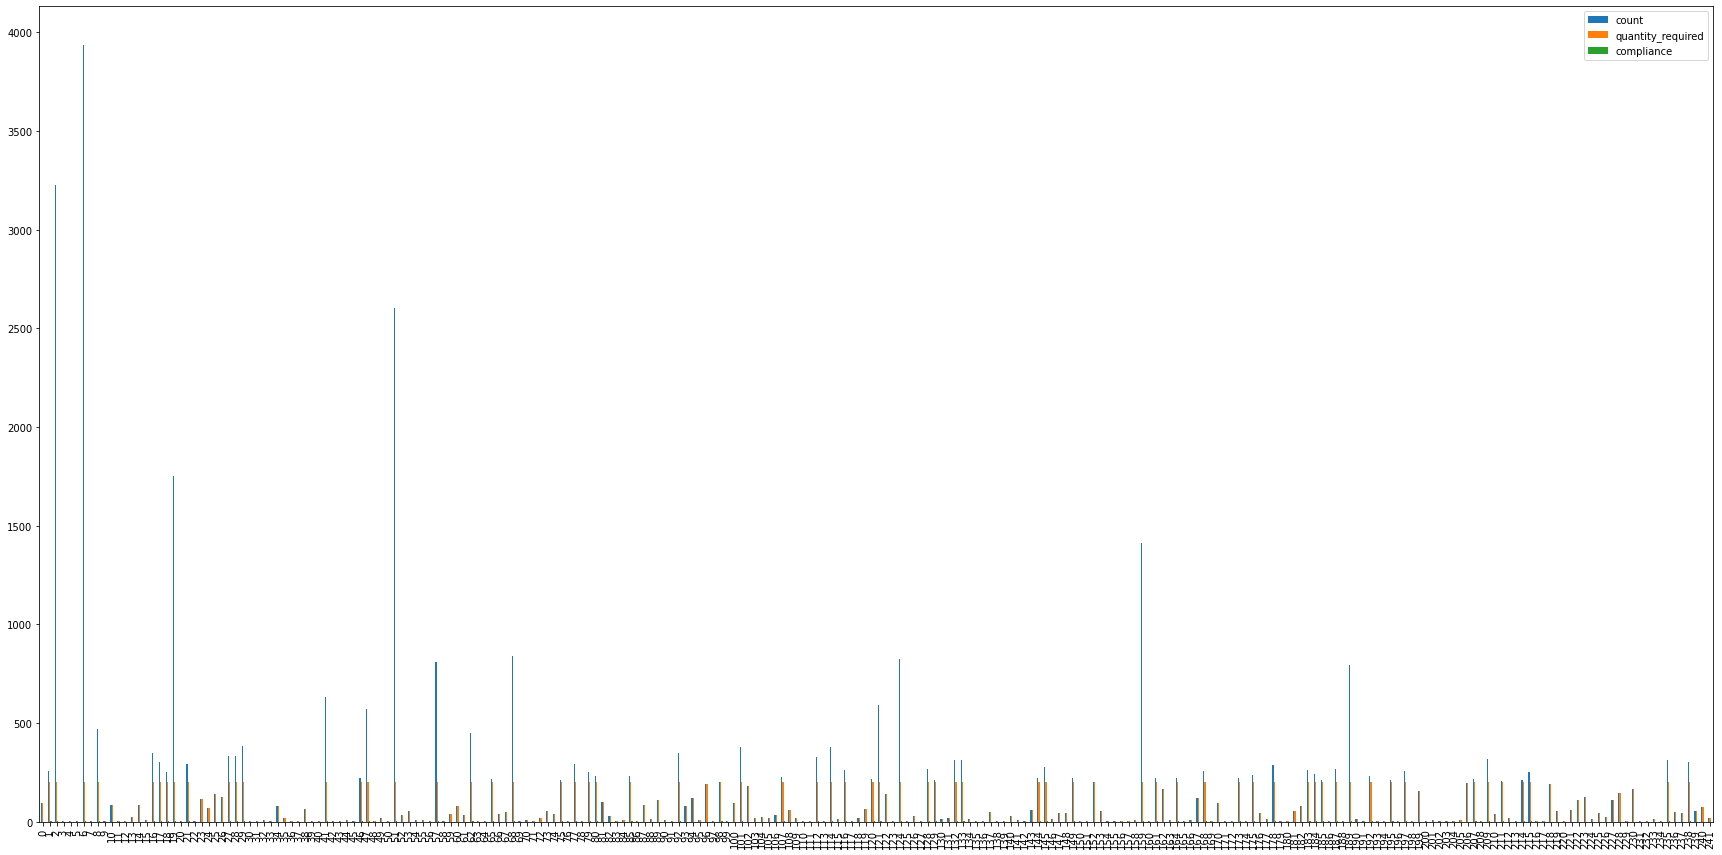

In [ ]:
def calculate_tag(df, pid, dataset_name, label_range):
    '''
    label_range: Number range of a single label
    '''
    start, end = label_range
    spo = df['spo_list'].explode().reset_index(drop=True)
    spo_group = spo.apply(lambda x: '-'.join([x['predicate'] , x['subject_type'], x['object_type']]))
    spo_group_count = spo_group.groupby(spo_group).count().reset_index(name='count')
    spo_group_count['quantity_required'] = spo_group_count['count'].apply(lambda x: start if start <= x < end  else x)
    spo_group_count['compliance'] = spo_group_count['count'].apply(lambda x: 1 if start <= x < end  else 0)
    spo_group_count.to_csv('./data/' + dataset_name + '_spo_group_count.csv', index=False, encoding='utf_8_sig')
    spo_group_count.plot(kind='bar', figsize=(30,15))
    print(f"Total number of p2id category is {len(p2id)}, actual number of labels that meet the requirements is {spo_group_count['compliance'].sum()}")
    print(f"Spo count is {spo_group_count['count'].sum()}, number of valid labels is {spo_group_count['quantity_required'].sum()}")
    return spo_group_count

dataset_name = '招股说明书'
label_range = [200, float('inf')]
spo_group_count = calculate_tag(df, p2id, dataset_name, label_range)
spo_count = spo_group_count['count'].sum()

In [ ]:
def proceed_data(text_list, spo_list, p2id, tokenizer, MAX_LEN, spo_count):
    id_label = {}
    ct = len(text_list)
    MAX_LEN = MAX_LEN
    input_ids = np.zeros((spo_count,MAX_LEN),dtype='int32')
    attention_mask = np.zeros((spo_count,MAX_LEN),dtype='int32')
    start_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    end_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    send_s_po = np.zeros((spo_count,2),dtype='int32')
    object_start_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    object_end_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    index_vaild = -1
    for k in range(ct):
        context_k = text_list[k].lower().replace(' ','')
        enc_context = tokenizer.encode(context_k,max_length=MAX_LEN,truncation=True)      
        start = []
        S_index = []
        for j in range(len(spo_list[k])):
            answers_text_k = spo_list[k][j]['subject'].lower().replace(' ','')
            chars = np.zeros((len(context_k)))
            index = context_k.find(answers_text_k)
            chars[index:index+len(answers_text_k)]=1
            offsets = []
            idx=0
            for t in enc_context[1:]:
                w = tokenizer.decode([t])
                if '#' in w and len(w)>1:
                    w = w.replace('#','')
                if w == '[UNK]':
                    w = '。'
                offsets.append((idx,idx+len(w)))
                idx += len(w)
            toks = []
            for i,(a,b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm>0: 
                    toks.append(i) 
            if len(toks)>0:
                S_start = toks[0]+1
                S_end = toks[-1]+1
                if (S_start,S_end) not in start:
                    index_vaild += 1
                    start.append((S_start,S_end))
                    input_ids[index_vaild,:len(enc_context)] = enc_context
                    attention_mask[index_vaild,:len(enc_context)] = 1
                    start_tokens[index_vaild,S_start] = 1
                    end_tokens[index_vaild,S_end] = 1
                    send_s_po[index_vaild,0] = S_start
                    send_s_po[index_vaild,1] = S_end
                    S_index.append([j,index_vaild])
                else:
                    S_index.append([j,index_vaild])
        if len(S_index) > 0:
            for index_ in range(len(S_index)):
                #随机选取object的首位，如果选取错误，则作为负样本
                object_text_k = spo_list[k][S_index[index_][0]]['object'].lower().replace(' ','')
                predicate = spo_list[k][S_index[index_][0]]['predicate']
                p_id = p2id[predicate]
                chars = np.zeros((len(context_k)))
                index = context_k.find(object_text_k)
                chars[index:index+len(object_text_k)]=1
                offsets = [] 
                idx = 0
                for t in enc_context[1:]:
                    w = tokenizer.decode([t])
                    if '#' in w and len(w)>1:
                        w = w.replace('#','')
                    if w == '[UNK]':
                        w = '。'
                    offsets.append((idx,idx+len(w)))
                    idx += len(w)
                toks = []
                for i,(a,b) in enumerate(offsets):
                    sm = np.sum(chars[a:b])
                    if sm>0: 
                        toks.append(i) 
                if len(toks)>0:
                    id_label[p_id] = predicate
                    P_start = toks[0]+1
                    P_end = toks[-1]+1
                    object_start_tokens[S_index[index_][1]][P_start,p_id] = 1
                    object_end_tokens[S_index[index_][1]][P_end,p_id] = 1
    return input_ids[:index_vaild], attention_mask[:index_vaild], start_tokens[:index_vaild], end_tokens[:index_vaild], send_s_po[:index_vaild], \
           object_start_tokens[:index_vaild], object_end_tokens[:index_vaild], id_label

In [ ]:
%%time
MAX_LEN = 256  
pretrained_path = '../model_dirs/chinese-bert-wwm-ext'  
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
input_ids, attention_mask, start_tokens, end_tokens, send_s_po, object_start_tokens, object_end_tokens, id_label \
= proceed_data(train_text, train_spo, p2id, tokenizer, MAX_LEN, spo_count)

print(f'start tokens shape: {start_tokens.shape}')

val_inputs = tokenizer(dev_text, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='tf') 
val_input_ids, val_attention_mask = val_inputs['input_ids'], val_inputs['attention_mask']

In [ ]:
def new_loss(true,pred):
    true = tf.cast(true,tf.float32)
    loss = K.sum(K.binary_crossentropy(true, pred))
    return loss

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    """(Conditional) Layer Normalization
    hidden_*系列参数仅为有条件输入时(conditional=True)使用
    """
    def __init__(
        self,
        center=True,
        scale=True,
        epsilon=None,
        conditional=False,
        hidden_units=None,
        hidden_activation='linear',
        hidden_initializer='glorot_uniform',
        **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.center = center
        self.scale = scale
        self.conditional = conditional
        self.hidden_units = hidden_units
        self.hidden_activation = tf.keras.activations.get(hidden_activation)
        self.hidden_initializer = tf.keras.initializers.get(hidden_initializer)
        self.epsilon = epsilon or 1e-12
        
    def compute_mask(self, inputs, mask=None):
        if self.conditional:
            masks = mask if mask is not None else []
            masks = [m[None] for m in masks if m is not None]
            if len(masks) == 0:
                return None
            else:
                return K.all(K.concatenate(masks, axis=0), axis=0)
        else:
            return mask
        
    def build(self, input_shape):
        super(LayerNormalization, self).build(input_shape)
        if self.conditional:
            shape = (input_shape[0][-1],)
        else:
            shape = (input_shape[-1],)
        if self.center:
            self.beta = self.add_weight(
                shape=shape, initializer='zeros', name='beta')
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape, initializer='ones', name='gamma')
        if self.conditional:
            if self.hidden_units is not None:
                self.hidden_dense = tf.keras.layers.Dense(
                    units=self.hidden_units,
                    activation=self.hidden_activation,
                    use_bias=False,
                    kernel_initializer=self.hidden_initializer)
            if self.center:
                self.beta_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')
            if self.scale:
                self.gamma_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')

    def call(self, inputs):
        """如果是条件Layer Norm，则默认以list为输入，第二个是condition
        """
        if self.conditional:
            inputs, cond = inputs
            if self.hidden_units is not None:
                cond = self.hidden_dense(cond)
            for _ in range(K.ndim(inputs) - K.ndim(cond)):
                cond = K.expand_dims(cond, 1)
            if self.center:
                beta = self.beta_dense(cond) + self.beta
            if self.scale:
                gamma = self.gamma_dense(cond) + self.gamma
        else:
            if self.center:
                beta = self.beta
            if self.scale:
                gamma = self.gamma
        outputs = inputs
        if self.center:
            mean = K.mean(outputs, axis=-1, keepdims=True)
            outputs = outputs - mean
        if self.scale:
            variance = K.mean(K.square(outputs), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            outputs = outputs / std
            outputs = outputs * gamma
        if self.center:
            outputs = outputs + beta
        return outputs


In [ ]:
def extract_subject(inputs):
    """根据subject_ids从output中取出subject的向量表征
    """
    output, subject_ids = inputs
    start = tf.gather(output,subject_ids[:,0],axis=1,batch_dims=1)
    end = tf.gather(output,subject_ids[:,1],axis=1,batch_dims=1)
    subject = tf.keras.layers.Concatenate(axis=1)([start, end])
    return subject
'''
   output.shape = 
   (None,128,768)
   subjudec_ids.shape = (None,2)
   start.shape = (None,None,768)
   subject.shape = (None,None,1536)
   subject[:,0].shape = (None,1536)
   这一部分给出各个变量的shape应该一目了然
'''
   
def build_model_2(pretrained_path, MAX_LEN, p2id):
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    s_po_index =  tf.keras.layers.Input((2,), dtype=tf.int32)
    
    bert_model = TFBertModel.from_pretrained(pretrained_path, output_hidden_states=True)
    outputs = bert_model(ids, attention_mask=att)
    x, _, hidden_states  = outputs[:3]
    layer_1 = hidden_states[-1]
    start_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    start_logits = tf.keras.layers.Lambda(lambda x: x**2)(start_logits)
    
    end_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    end_logits = tf.keras.layers.Lambda(lambda x: x**2)(end_logits)
    
    subject_1 = extract_subject([layer_1,s_po_index])
    Normalization_1 = LayerNormalization(conditional=True)([layer_1, subject_1])
    
    op_out_put_start = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_start = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_start)
    
    op_out_put_end = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_end = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_end)
    
    model = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[start_logits, end_logits, op_out_put_start, op_out_put_end])
    model_2 = tf.keras.models.Model(inputs=[ids, att], outputs=[start_logits,end_logits])
    model_3 = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[op_out_put_start, op_out_put_end])
    return model, model_2, model_3


In [ ]:
def rematch_text_word(tokenizer,text,enc_context,enc_start,enc_end):
    span = [a.span()[0] for a in re.finditer(' ', text)]
    decode_list = [tokenizer.decode([i]) for i in enc_context][1:]
    start = 0
    end = 0
    len_start = 0
    for i in range(len(decode_list)):
        if i ==  enc_start - 1:
            start = len_start
        j = decode_list[i]
        if '#' in j and len(j)>1:
            j = j.replace('#','')
        if j == '[UNK]':
            j = '。'
        len_start += len(j)
        if i == enc_end - 1:
            end = len_start
            break
    for span_index in span:
        if start >= span_index:
            start += 1
            end += 1
        if end > span_index and span_index>start:
            end += 1
    return text[start:end]


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self,model_2, model_3, id2tag, va_text_list, va_spo_list, va_input_ids, va_attention_mask, tokenizer):
        super(Metrics, self).__init__()
        self.model_2 = model_2
        self.model_3 = model_3
        self.id2tag = id2tag
        self.va_input_ids = va_input_ids
        self.va_attention_mask = va_attention_mask
        self.va_spo_list = va_spo_list
        self.va_text_list = va_text_list
        self.tokenizer = tokenizer
        
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.best_val_f1 = 0
    
    def get_same_element_index(self,ob_list):
        return [i for (i, v) in enumerate(ob_list) if v == 1]
    
    def evaluate_data(self):
        Y1 = self.model_2.predict([self.va_input_ids,self.va_attention_mask])
        question=[]
        answer=[]
        for m in range(len(Y1[0])):
            for z in self.va_spo_list[m]:
                question.append((z['subject'],z['predicate'],z['object']))
            start = np.where(Y1[0][m]>0.5)[0]
            end = np.where(Y1[1][m]>0.5)[0]
            subjects = []
            for i in start:
                j = end[end >= i]
                if len(j) > 0:
                    j = j[0]
                    subjects.append((i, j))
            if subjects:
                token_ids_2 = np.repeat([self.va_input_ids[m]], len(subjects), 0)
                attention_mask_2 = np.repeat([self.va_attention_mask[m]], len(subjects), 0)
                subjects = np.array(subjects)
                object_preds_start,object_preds_end = self.model_3.predict([token_ids_2, attention_mask_2, subjects])
                for subject,object_start,object_end in zip(subjects,object_preds_start,object_preds_end):
                    sub = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],subject[0],subject[1])
                    start = np.argwhere(object_start > 0.5)
                    end = np.argwhere(object_end > 0.5)
                    for _start, predicate1 in start:
                        for _end, predicate2 in end:
                            if _start <= _end and predicate1 == predicate2:
                                ans = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],_start,_end)
                                answer.append((sub,self.id2tag[predicate1],ans))
                                break
        Q = set(question)
        S = set(answer)
        f1 = 2*len(Q&S)/(len(Q)+len(S))
        return f1
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        _val_f1 = self.evaluate_data()
        self.val_f1s.append(_val_f1)
        logs['val_f1'] = _val_f1
        if _val_f1 > self.best_val_f1:
            self.model.save_weights('../model_dirs/fine_tune_relation_extraction/09_f1={}_model.h5'.format(round(_val_f1,4)))
            self.best_val_f1 = _val_f1
            print("best f1: {} \n".format(self.best_val_f1))
        else:
            print("val f1: {}, but not the best f1 \n".format(_val_f1))
        return      

In [ ]:
def rematch_text_word(tokenizer, text,enc_context, enc_start, enc_end):
    span = [a.span()[0] for a in re.finditer(' ', text)]
    decode_list = [tokenizer.decode([i]) for i in enc_context][1:]
    start = 0
    end = 0
    len_start = 0
    for i in range(len(decode_list)):
        if i ==  enc_start - 1:
            start = len_start
        j = decode_list[i]
        if '#' in j and len(j)>1:
            j = j.replace('#','')
        if j == '[UNK]':
            j = '。'
        len_start += len(j)
        if i == enc_end - 1:
            end = len_start
            break
    for span_index in span:
        if start >= span_index:
            start += 1
            end += 1
        if end > span_index and span_index>start:
            end += 1
    return text[start:end]


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self,model_2, model_3, id2tag, va_text_list, va_spo_list, va_input_ids, va_attention_mask, tokenizer, folder_path):
        super(Metrics, self).__init__()
        self.model_2 = model_2
        self.model_3 = model_3
        self.id2tag = id2tag
        self.va_input_ids = va_input_ids
        self.va_attention_mask = va_attention_mask
        self.va_spo_list = va_spo_list
        self.va_text_list = va_text_list
        self.tokenizer = tokenizer
        
        
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.best_val_f1 = 0
    
    def get_same_element_index(self,ob_list):
        return [i for (i, v) in enumerate(ob_list) if v == 1]
    
    def evaluate_data(self):
        Y1 = self.model_2.predict([self.va_input_ids,self.va_attention_mask])
        question=[]
        answer=[]
        for m in range(len(Y1[0])):
            for z in self.va_spo_list[m]:
                question.append((z['subject'],z['predicate'],z['object']))
            start = np.where(Y1[0][m]>0.5)[0]
            end = np.where(Y1[1][m]>0.5)[0]
            subjects = []
            for i in start:
                j = end[end >= i]
                if len(j) > 0:
                    j = j[0]
                    subjects.append((i, j))
            if subjects:
                token_ids_2 = np.repeat([self.va_input_ids[m]], len(subjects), 0)
                attention_mask_2 = np.repeat([self.va_attention_mask[m]], len(subjects), 0)
                subjects = np.array(subjects)
                object_preds_start,object_preds_end = self.model_3.predict([token_ids_2, attention_mask_2, subjects])
                for subject,object_start,object_end in zip(subjects,object_preds_start,object_preds_end):
                    sub = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],subject[0],subject[1])
                    start = np.argwhere(object_start > 0.5)
                    end = np.argwhere(object_end > 0.5)
                    for _start, predicate1 in start:
                        for _end, predicate2 in end:
                            if _start <= _end and predicate1 == predicate2:
                                ans = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],_start,_end)
                                answer.append((sub,self.id2tag[predicate1],ans))
                                break
        Q = set(question)
        S = set(answer)
        f1 = 2*len(Q&S)/(len(Q)+len(S))
        return f1
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        _val_f1 = self.evaluate_data()
        self.val_f1s.append(_val_f1)
        logs['val_f1'] = _val_f1
        if _val_f1 > self.best_val_f1:
            self.model.save_weights(os.path.join(folder_path, f'f1={round(_val_f1, 4)}_model.h5'))
            self.best_val_f1 = _val_f1
            print("best f1: {} \n".format(self.best_val_f1))
        else:
            print("val f1: {}, but not the best f1 \n".format(_val_f1))
        return  

In [ ]:
folder_path = '../model_dirs/fine_tune_relation_extraction'
epochs = 20
batch_size = 2

In [ ]:
# config = BertConfig.from_json_file('../model_dirs/chinese-bert-wwm-ext/config.json')
# TFBertModel.from_pretrained(pretrained_path, config=config)
K.clear_session()
model,model_2,model_3 = build_model_2(pretrained_path,  MAX_LEN, p2id)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss={'lambda': new_loss,
                'lambda_1': new_loss,
                'lambda_2': new_loss,
                'lambda_3': new_loss},optimizer=optimizer)
model.fit([input_ids, attention_mask, send_s_po], [start_tokens, end_tokens, object_start_tokens, object_end_tokens], \
        epochs=epochs, batch_size=batch_size, callbacks=[Metrics(model_2, model_3 ,id2p, dev_text, dev_spo, val_input_ids, val_attention_mask, tokenizer, folder_path)])

# h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
# model.save_weights(h5_path)
# checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
# model.save_weights(checkpoint_path)

In [ ]:
pretrained_path = '../model_dirs/chinese-bert-wwm-ext'
checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
model,model_2,model_3 = build_model_2(pretrained_path, MAX_LEN, p2id)
model.load_weights(h5_path)

In [ ]:
idx = 0
x1 = [input_ids[[idx]], attention_mask[[idx]]]
sub_start_tokens, sub_end_tokens = model_2.predict(x1)
train_spo[idx], p2id[train_spo[idx][0]['predicate']]

In [ ]:
sub_start_idx = int(np.argwhere(sub_start_tokens[0,:,0] > 0.5)[0])
sub_end_idx = int(np.argwhere(sub_end_tokens[0,:,0] > 0.5)[0])
sub_text = tokenizer.decode(input_ids[idx][sub_start_idx:sub_end_idx+1]).replace(' ','')
sub_text

In [ ]:
x2 = [input_ids[[idx]], attention_mask[[idx]], send_s_po[[idx]]]
obj_start_tokens, obj_end_tokens = model_3.predict(x2)
obj_start_tokens.shape

In [ ]:
obj_start_idx = np.argwhere(obj_start_tokens[0] > 0.5)
obj_end_idx = np.argwhere(obj_end_tokens[0] > 0.5)
for _start, predicate1 in obj_start_idx:
    for _end, predicate2 in obj_end_idx:
        if _start <= _end and predicate1 == predicate2:
            print(_start, _end, predicate1)
            obj_text = tokenizer.decode(input_ids[idx][_start:_end+1]).replace(' ','')
            print(obj_text, id2p[predicate1])

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid

In [ ]:
!nvidia-smi